In [ ]:
!pip install ctreelearn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import ctl
import torch
import time
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = (16,16)


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu


# **Imagens**

In [ ]:
!gdown --id 1ie1mxAkO1AJRlXKWmuL0Yfef3is0kOem
!unzip dat.zip

from IPython import display
display.clear_output()

# **Max-tree área e inércia**

Tamanho do dataset: 1019
Tamanho do trainset: 764
Tamanho do testset: 255
Quantidade de atributos: 29
Atributos: {'AREA': 0, 'VOLUME': 1, 'LEVEL': 2, 'MEAN_LEVEL': 3, 'VARIANCE_LEVEL': 4, 'STANDARD_DEVIATION': 5, 'BOX_WIDTH': 6, 'BOX_HEIGHT': 7, 'RECTANGULARITY': 8, 'RATIO_WH': 9, 'CENTRAL_MOMENT_20': 10, 'CENTRAL_MOMENT_02': 11, 'CENTRAL_MOMENT_11': 12, 'CENTRAL_MOMENT_30': 13, 'CENTRAL_MOMENT_03': 14, 'CENTRAL_MOMENT_21': 15, 'CENTRAL_MOMENT_12': 16, 'ORIENTATION': 17, 'LENGTH_MAJOR_AXIS': 18, 'LENGTH_MINOR_AXIS': 19, 'ECCENTRICITY': 20, 'COMPACTNESS': 21, 'HU_MOMENT_1_INERTIA': 22, 'HU_MOMENT_2': 23, 'HU_MOMENT_3': 24, 'HU_MOMENT_4': 25, 'HU_MOMENT_5': 26, 'HU_MOMENT_6': 27, 'HU_MOMENT_7': 28}


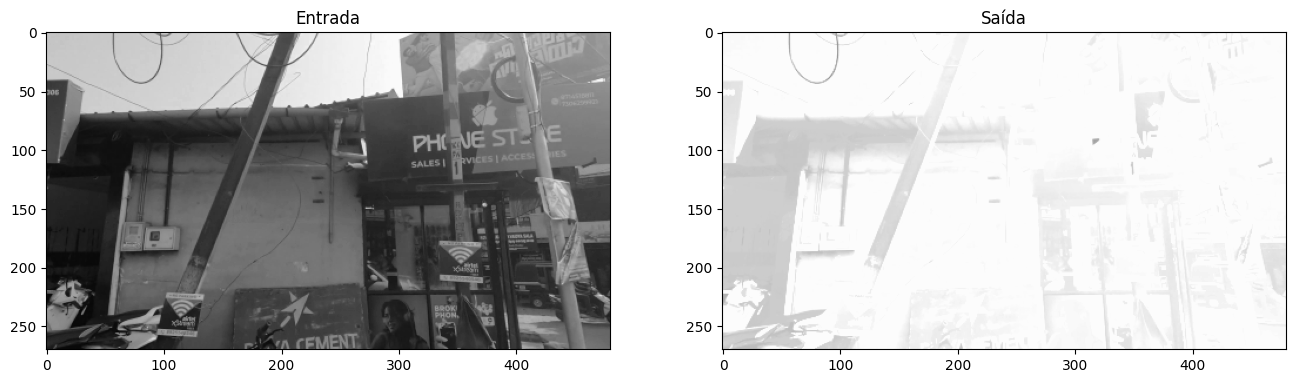

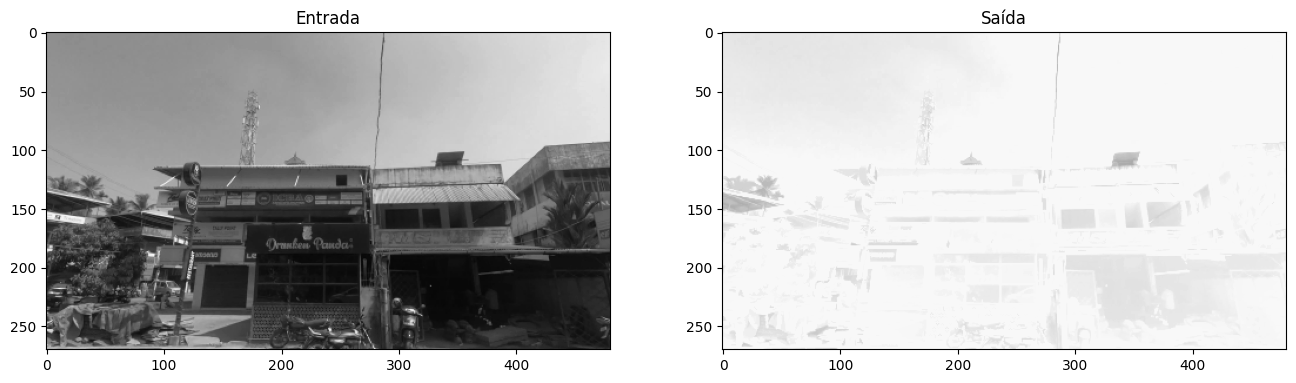

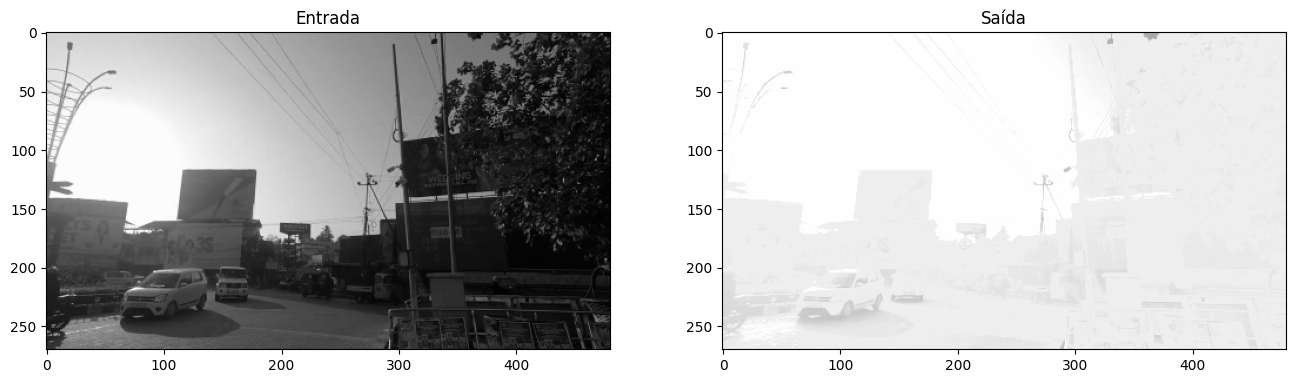

In [ ]:
class AreaFilteringImagesDataset(ctl.dataset.FilteringImagesDataset):
    def filter(self, img_vector, num_rows, num_cols):
        tree = ctl.ComponentTree(img_vector, num_rows, num_cols, False, 1.5)
        features, attrs = ctl.Attribute.computerBasicAttributes(tree)
        attr_area = attrs[:, features["HU_MOMENT_1_INERTIA"]] #HU_MOMENT_1_INERTIA
        attr_filter = ctl.AttributeFilters(tree)
        output = attr_filter.filteringSubtractiveRule(attr_area > 0.16)
        return output

num_rows, num_cols = (270, 480) #25% do tamanho original (1080x1920)
isMaxtree = False
dataset = AreaFilteringImagesDataset("/content/dat/dataset-icdar2024_occluded/", num_rows, num_cols, isMaxtree)
#dataset.set_features({"AREA": 0})

print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25, normalization=True, random_state=42)

print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))
print("Quantidade de atributos:", len(dataset.get_features()))
print("Atributos:", dataset.get_features())

for i in range(3):
    x, y = trainset[i]

    plt.subplot(1,2,1)
    plt.imshow(x.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Entrada')

    plt.subplot(1,2,2)
    plt.imshow(y.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Saída')
    plt.show()

In [ ]:
dataset.set_features({"HU_MOMENT_1_INERTIA": 22})
print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25, normalization=True)
print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))
print("Quantidade de atributos:", len(dataset.get_features()))
print("Atributos:", dataset.get_features())

Tamanho do dataset: 1019
Tamanho do trainset: 764
Tamanho do testset: 255
Quantidade de atributos: 1
Atributos: {'HU_MOMENT_1_INERTIA': 22}


In [ ]:
class AreaFilteringImagesDataset(ctl.dataset.FilteringImagesDataset):
    def filter(self, img_vector, num_rows, num_cols):
        tree = ctl.ComponentTree(img_vector, num_rows, num_cols, False, 1.5)
        features, attrs = ctl.Attribute.computerBasicAttributes(tree)
        attr_area = attrs[:, features["HU_MOMENT_1_INERTIA"]] #HU_MOMENT_1_INERTIA
        attr_filter = ctl.AttributeFilters(tree)
        output = attr_filter.filteringSubtractiveRule(attr_area > 0.16)
        return output

num_rows, num_cols = (270, 480) #25% do tamanho original (1080x1920)
isMaxtree = False
dataset = AreaFilteringImagesDataset("/content/dat/dataset-icdar2024_occluded/", num_rows, num_cols, isMaxtree)
#dataset.set_features({"AREA" : 0})
print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25, normalization=True, random_state=42) # Testar
print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))

for i in range(1):
    x, y = trainset[i]

    plt.subplot(1,2,1)
    plt.imshow(x.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Entrada')

    plt.subplot(1,2,2)
    plt.imshow(y.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Saída')
    plt.show()

In [ ]:
import pandas as pd

attribute = "AREA"

errors = []
# Função para calcular percentual de pixels diferentes
def percentualPixelsDiferentes(y_true, y_pred):
    rows, cols = y_true.shape
    sum_diff = 0
    for i in range(rows):
        dif = np.sum(y_true[i, :] != y_pred[i, :])
        sum_diff += (dif / cols)
    return (sum_diff / rows) * 100

# Função para calcular o PSNR
def psnr(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

def ssim_metric(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=255.0, multichannel=False)


# Diretório para salvar os modelos
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)

# Listas de hiperparâmetros
ls_batch_size = [1]# 2,4,8,16,32,64,len(trainset)
ls_learning_rate = [0.1] #  0.01, 0.001, 0.0001

# Dicionários para registrar tempos e métricas
training_times = {}
metrics_results = {}

# Loop pelos hiperparâmetros
for batch_size in ls_batch_size:
    for learning_rate in ls_learning_rate:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")

        # Criação do modelo
        print("Criando o modelo")
        model = ctl.models.DifferentialMorphologicalTree(trainset)
        print("Model created")

        # DataLoader para o conjunto de treinamento
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

        # Função de perda e otimizador
        loss_function = ctl.models.TreeLossFunction(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Treinamento
        model.train()
        time_begin = time.time()
        n_epocas = 50

        for epoch in range(n_epocas):
            for i, exemplos in enumerate(trainloader, 0):
                entradas, saida_desejadas = exemplos

                # Zerar gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward pass
                saida_predicoes = model(entradas)

                # Calcular a perda
                loss = loss_function(entradas, saida_desejadas, saida_predicoes)

                # Backward pass + otimização
                loss.backward()
                optimizer.step()

                errors.append(loss.item())
                if i % 100 == 0:  # Imprimir a cada 10 iterações
                  print("Época:", epoch, "Iteração:", i, "Loss:", loss.item())


        time_end = time.time()  # Fim do temporizador
        elapsed_time = time_end - time_begin  # Tempo gasto
        training_times[(batch_size, learning_rate)] = elapsed_time

        print("Fim do treinamento")
        print("Inicio Avaliação e cálculo de métricas")

        # Avaliação e cálculo de métricas
        X_train, y_train = trainset.get_dataXy()
        X_test, y_test = testset.get_dataXy()
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        with torch.no_grad():
            y_pred_train = model(X_train).numpy()
            y_pred_test = model(X_test).numpy()

            # Método alternativo de predição (se disponível)
            y_pred_train2 = model.predict(X_train)
            y_pred_test2 = model.predict(X_test)

        # Cálculo de métricas
        data_range = 255.0  # Ajuste para o intervalo correto das suas imagens
        metrics_results[(batch_size, learning_rate)] = {
            "Train (score)": {
                "MSE": mean_squared_error(y_train, y_pred_train),
                "MAE": mean_absolute_error(y_train, y_pred_train),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train),
                "PSNR": psnr(y_train, y_pred_train),
                "SSIM": ssim(y_train, y_pred_train, multichannel=False, data_range=data_range),
            },
            "Train (predict)": {
                "MSE": mean_squared_error(y_train, y_pred_train2),
                "MAE": mean_absolute_error(y_train, y_pred_train2),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train2),
                "PSNR": psnr(y_train, y_pred_train2),
                "SSIM": ssim(y_train, y_pred_train2, multichannel=False, data_range=data_range),
            },
            "Test (score)": {
                "MSE": mean_squared_error(y_test, y_pred_test),
                "MAE": mean_absolute_error(y_test, y_pred_test),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test),
                "PSNR": psnr(y_test, y_pred_test),
                "SSIM": ssim(y_test, y_pred_test, multichannel=False, data_range=data_range),
            },
            "Test (predict)": {
                "MSE": mean_squared_error(y_test, y_pred_test2),
                "MAE": mean_absolute_error(y_test, y_pred_test2),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test2),
                "PSNR": psnr(y_test, y_pred_test2),
                "SSIM": ssim(y_test, y_pred_test2, multichannel=False, data_range=data_range),
            },
        }

        df_metrics = pd.DataFrame(metrics_results)

        # Salvar como arquivo Excel
        output_path = f"{attribute}_max_tree_model_weights_bs{batch_size}_lr_{learning_rate}.xlsx"
        df_metrics.to_excel(output_path, index=True)

        # Salvar os pesos ao final do treinamento
        model_path = os.path.join(output_dir, f"{attribute}_max_tree_model_weights_bs{batch_size}_lr{learning_rate}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Pesos salvos em: {model_path}")
        print("")



Batch size: 1, Learning rate: 0.1
Criando o modelo
Model created
Época: 0 Iteração: 0 Loss: 5302.935546875
Época: 0 Iteração: 100 Loss: 136.67611694335938
Época: 0 Iteração: 200 Loss: 93.76513671875
Época: 0 Iteração: 300 Loss: 55.57057189941406
Época: 0 Iteração: 400 Loss: 494.6446228027344
Época: 0 Iteração: 500 Loss: 28.6943359375
Época: 0 Iteração: 600 Loss: 6.556493282318115
Época: 0 Iteração: 700 Loss: 11.456755638122559
Época: 1 Iteração: 0 Loss: 50.131858825683594
Época: 1 Iteração: 100 Loss: 39.04469680786133
Época: 1 Iteração: 200 Loss: 14.78085994720459
Época: 1 Iteração: 300 Loss: 6.300792217254639
Época: 1 Iteração: 400 Loss: 3.6495895385742188
Época: 1 Iteração: 500 Loss: 13.96200180053711
Época: 1 Iteração: 600 Loss: 6.1353044509887695
Época: 1 Iteração: 700 Loss: 2.09120512008667
Época: 2 Iteração: 0 Loss: 3.08271861076355
Época: 2 Iteração: 100 Loss: 7.896113872528076
Época: 2 Iteração: 200 Loss: 3.6097612380981445
Época: 2 Iteração: 300 Loss: 1.4523838758468628
Época:

# **Max-tree inércia**

Tamanho do dataset: 1019
Tamanho do trainset: 764
Tamanho do testset: 255
Quantidade de atributos: 1
Atributos: {'HU_MOMENT_1_INERTIA': 22}


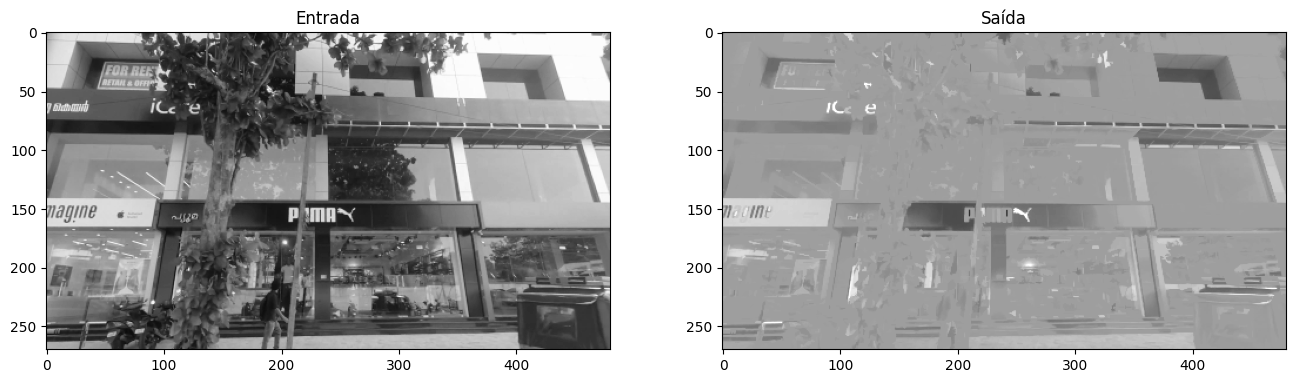

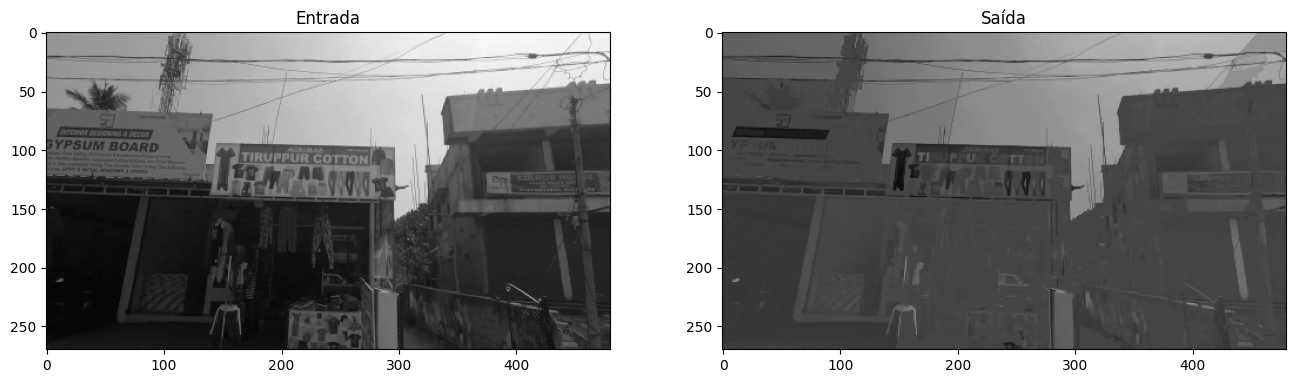

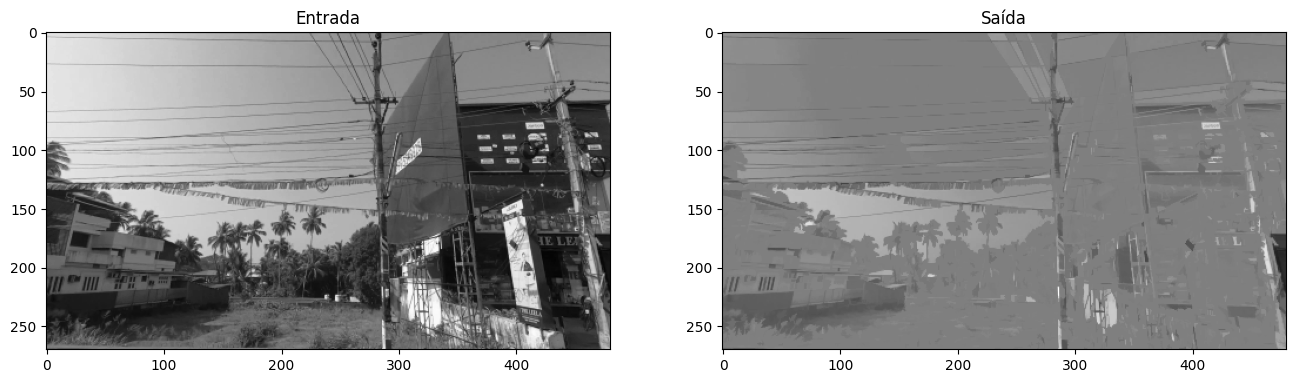

In [ ]:

class AreaFilteringImagesDataset(ctl.dataset.FilteringImagesDataset):
    def filter(self, img_vector, num_rows, num_cols):
        tree = ctl.ComponentTree(img_vector, num_rows, num_cols)
        features, attrs = ctl.Attribute.computerBasicAttributes(tree)
        attr_area = attrs[:, features["HU_MOMENT_1_INERTIA"]]
        attr_filter = ctl.AttributeFilters(tree)
        output = attr_filter.filteringSubtractiveRule(attr_area > 0.16)
        return output


num_rows, num_cols = (270, 480) #25% do tamanho original (1080x1920)
tree_type = 1 # 0-mintree, 1-maxtree, 2-ToS

dataset = AreaFilteringImagesDataset("/content/dat/dataset-icdar2024_occluded/", num_rows, num_cols, tree_type)
dataset.set_features({"HU_MOMENT_1_INERTIA": 22})
print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25, normalization=True)
print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))
print("Quantidade de atributos:", len(dataset.get_features()))
print("Atributos:", dataset.get_features())

for i in range(3):
    x, y = trainset[i]

    plt.subplot(1,2,1)
    plt.imshow(x.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Entrada')

    plt.subplot(1,2,2)
    plt.imshow(y.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Saída')
    plt.show()



In [ ]:
errors = []
attribute ="HU_MOMENT_1_INERTIA"
# Função para calcular percentual de pixels diferentes
def percentualPixelsDiferentes(y_true, y_pred):
    rows, cols = y_true.shape
    sum_diff = 0
    for i in range(rows):
        dif = np.sum(y_true[i, :] != y_pred[i, :])
        sum_diff += (dif / cols)
    return (sum_diff / rows) * 100

# Função para calcular o PSNR
def psnr(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

def ssim_metric(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=255.0, multichannel=False)  # Assume imagens em escala de cinza


# Diretório para salvar os modelos
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)

# Listas de hiperparâmetros
ls_batch_size = [1] # 2,4,8,16,32,64,len(trainset)
ls_learning_rate = [0.1] # 0.01, 0.001, 0.0001

# Dicionários para registrar tempos e métricas
training_times = {}
metrics_results = {}

# Loop pelos hiperparâmetros
for batch_size in ls_batch_size:
    for learning_rate in ls_learning_rate:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")

        # Criação do modelo
        print("Criando o modelo")
        model = ctl.models.DifferentialMorphologicalTree(trainset)
        print("Model created")

        # DataLoader para o conjunto de treinamento
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

        # Função de perda e otimizador
        loss_function = ctl.models.TreeLossFunction(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Treinamento
        model.train()
        time_begin = time.time()
        n_epocas = 50

        for epoch in range(n_epocas):
            for i, exemplos in enumerate(trainloader, 0):
                entradas, saida_desejadas = exemplos

                # Zerar gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward pass
                saida_predicoes = model(entradas)

                # Calcular a perda
                loss = loss_function(entradas, saida_desejadas, saida_predicoes)

                # Backward pass + otimização
                loss.backward()
                optimizer.step()

                errors.append(loss.item())
                if i % 100 == 0:  # Imprimir a cada 10 iterações
                  print("Época:", epoch, "Iteração:", i, "Loss:", loss.item())


        time_end = time.time()  # Fim do temporizador
        elapsed_time = time_end - time_begin  # Tempo gasto
        training_times[(batch_size, learning_rate)] = elapsed_time

        print("Fim do treinamento")
        print("Inicio Avaliação e cálculo de métricas")

        # Avaliação e cálculo de métricas
        X_train, y_train = trainset.get_dataXy()
        X_test, y_test = testset.get_dataXy()
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        with torch.no_grad():
            y_pred_train = model(X_train).numpy()
            y_pred_test = model(X_test).numpy()

            # Método alternativo de predição (se disponível)
            y_pred_train2 = model.predict(X_train)
            y_pred_test2 = model.predict(X_test)

        # Cálculo de métricas
        data_range = 255.0  # Ajuste para o intervalo correto das suas imagens
        metrics_results[(batch_size, learning_rate)] = {
            "Train (score)": {
                "MSE": mean_squared_error(y_train, y_pred_train),
                "MAE": mean_absolute_error(y_train, y_pred_train),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train),
                "PSNR": psnr(y_train, y_pred_train),
                "SSIM": ssim(y_train, y_pred_train, multichannel=False, data_range=data_range),
            },
            "Train (predict)": {
                "MSE": mean_squared_error(y_train, y_pred_train2),
                "MAE": mean_absolute_error(y_train, y_pred_train2),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train2),
                "PSNR": psnr(y_train, y_pred_train2),
                "SSIM": ssim(y_train, y_pred_train2, multichannel=False, data_range=data_range),
            },
            "Test (score)": {
                "MSE": mean_squared_error(y_test, y_pred_test),
                "MAE": mean_absolute_error(y_test, y_pred_test),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test),
                "PSNR": psnr(y_test, y_pred_test),
                "SSIM": ssim(y_test, y_pred_test, multichannel=False, data_range=data_range),
            },
            "Test (predict)": {
                "MSE": mean_squared_error(y_test, y_pred_test2),
                "MAE": mean_absolute_error(y_test, y_pred_test2),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test2),
                "PSNR": psnr(y_test, y_pred_test2),
                "SSIM": ssim(y_test, y_pred_test2, multichannel=False, data_range=data_range),
            },
        }

        df_metrics = pd.DataFrame(metrics_results)

        # Salvar como arquivo Excel
        output_path = f"{attribute}_max_tree_model_weights_bs{batch_size}_lr_{learning_rate}.xlsx"
        df_metrics.to_excel(output_path, index=True)

        # Salvar os pesos ao final do treinamento
        model_path = os.path.join(output_dir, f"{attribute}_max_tree_model_weights_bs{batch_size}_lr{learning_rate}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Pesos salvos em: {model_path}")
        print("")



Batch size: 1, Learning rate: 0.1
Criando o modelo
Model created
Época: 0 Iteração: 0 Loss: 8428.7841796875
Época: 0 Iteração: 100 Loss: 2655.572265625
Época: 0 Iteração: 200 Loss: 1574.956298828125
Época: 0 Iteração: 300 Loss: 4101.92578125
Época: 0 Iteração: 400 Loss: 4339.1396484375
Época: 0 Iteração: 500 Loss: 4257.60791015625
Época: 0 Iteração: 600 Loss: 1400.9854736328125
Época: 0 Iteração: 700 Loss: 3337.6435546875
Época: 1 Iteração: 0 Loss: 2510.140869140625
Época: 1 Iteração: 100 Loss: 2390.2373046875
Época: 1 Iteração: 200 Loss: 1327.6942138671875
Época: 1 Iteração: 300 Loss: 2005.66796875
Época: 1 Iteração: 400 Loss: 5894.5888671875
Época: 1 Iteração: 500 Loss: 2760.27490234375
Época: 1 Iteração: 600 Loss: 3303.491455078125
Época: 1 Iteração: 700 Loss: 3362.519287109375
Época: 2 Iteração: 0 Loss: 2246.13134765625
Época: 2 Iteração: 100 Loss: 3515.03173828125
Época: 2 Iteração: 200 Loss: 3167.34326171875
Época: 2 Iteração: 300 Loss: 1765.696044921875
Época: 2 Iteração: 400 Lo

# **Min-tree área**

In [ ]:
class AreaFilteringImagesDataset(ctl.dataset.FilteringImagesDataset):
    def filter(self, img_vector, num_rows, num_cols):
        tree = ctl.ComponentTree(img_vector, num_rows, num_cols)
        features, attrs = ctl.Attribute.computerBasicAttributes(tree)
        attr_area = attrs[:, features["AREA"]]
        attr_filter = ctl.AttributeFilters(tree)
        output = attr_filter.filteringSubtractiveRule(attr_area > 4500)
        return output


num_rows, num_cols = (270, 480) #25% do tamanho original (1080x1920)
tree_type = 0 # 0-mintree, 1-maxtree, 2-ToS

dataset = AreaFilteringImagesDataset("/content/dat/dataset-icdar2024_occluded", num_rows, num_cols, tree_type)
dataset.set_features({"AREA": 0})

print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25,
                                             normalization=True,
                                             random_state=42)
print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))

for i in range(3):
    x, y = trainset[i]

    plt.subplot(1,2,1)
    plt.imshow(x.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Entrada')

    plt.subplot(1,2,2)
    plt.imshow(y.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Saída')
    plt.show()

In [ ]:
errors = []
# Função para calcular percentual de pixels diferentes
def percentualPixelsDiferentes(y_true, y_pred):
    rows, cols = y_true.shape
    sum_diff = 0
    for i in range(rows):
        dif = np.sum(y_true[i, :] != y_pred[i, :])
        sum_diff += (dif / cols)
    return (sum_diff / rows) * 100

# Função para calcular o PSNR
def psnr(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

def ssim_metric(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=255.0, multichannel=False)  # Assume imagens em escala de cinza


# Diretório para salvar os modelos
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)

# Listas de hiperparâmetros
ls_batch_size = [1,2,4,8,16,32,64,len(trainset)]
ls_learning_rate = [0.1, 0.01, 0.001, 0.0001]

# Dicionários para registrar tempos e métricas
training_times = {}
metrics_results = {}

# Loop pelos hiperparâmetros
for batch_size in ls_batch_size:
    for learning_rate in ls_learning_rate:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")

        # Criação do modelo
        print("Criando o modelo")
        model = ctl.models.DifferentialMorphologicalTree(trainset)
        print("Model created")

        # DataLoader para o conjunto de treinamento
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

        # Função de perda e otimizador
        loss_function = ctl.models.TreeLossFunction(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Treinamento
        model.train()
        time_begin = time.time()
        n_epocas = 50

        for epoch in range(n_epocas):
            for i, exemplos in enumerate(trainloader, 0):
                entradas, saida_desejadas = exemplos

                # Zerar gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward pass
                saida_predicoes = model(entradas)

                # Calcular a perda
                loss = loss_function(entradas, saida_desejadas, saida_predicoes)

                # Backward pass + otimização
                loss.backward()
                optimizer.step()

                errors.append(loss.item())
                if i % 100 == 0:  # Imprimir a cada 10 iterações
                  print("Época:", epoch, "Iteração:", i, "Loss:", loss.item())


        time_end = time.time()  # Fim do temporizador
        elapsed_time = time_end - time_begin  # Tempo gasto
        training_times[(batch_size, learning_rate)] = elapsed_time

        print("Fim do treinamento")
        print("Inicio Avaliação e cálculo de métricas")

        # Avaliação e cálculo de métricas
        X_train, y_train = trainset.get_dataXy()
        X_test, y_test = testset.get_dataXy()
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        with torch.no_grad():
            y_pred_train = model(X_train).numpy()
            y_pred_test = model(X_test).numpy()

            # Método alternativo de predição (se disponível)
            y_pred_train2 = model.predict(X_train)
            y_pred_test2 = model.predict(X_test)

        # Cálculo de métricas
        data_range = 255.0  # Ajuste para o intervalo correto das suas imagens
        metrics_results[(batch_size, learning_rate)] = {
            "Train (score)": {
                "MSE": mean_squared_error(y_train, y_pred_train),
                "MAE": mean_absolute_error(y_train, y_pred_train),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train),
                "PSNR": psnr(y_train, y_pred_train),
                "SSIM": ssim(y_train, y_pred_train, multichannel=False, data_range=data_range),
            },
            "Train (predict)": {
                "MSE": mean_squared_error(y_train, y_pred_train2),
                "MAE": mean_absolute_error(y_train, y_pred_train2),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train2),
                "PSNR": psnr(y_train, y_pred_train2),
                "SSIM": ssim(y_train, y_pred_train2, multichannel=False, data_range=data_range),
            },
            "Test (score)": {
                "MSE": mean_squared_error(y_test, y_pred_test),
                "MAE": mean_absolute_error(y_test, y_pred_test),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test),
                "PSNR": psnr(y_test, y_pred_test),
                "SSIM": ssim(y_test, y_pred_test, multichannel=False, data_range=data_range),
            },
            "Test (predict)": {
                "MSE": mean_squared_error(y_test, y_pred_test2),
                "MAE": mean_absolute_error(y_test, y_pred_test2),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test2),
                "PSNR": psnr(y_test, y_pred_test2),
                "SSIM": ssim(y_test, y_pred_test2, multichannel=False, data_range=data_range),
            },
        }

        df_metrics = pd.DataFrame(metrics_results)

        # Salvar como arquivo Excel
        output_path = f"{attribute}_min_tree_model_weights_bs{batch_size}_lr_{learning_rate}.xlsx"
        df_metrics.to_excel(output_path, index=True)

        # Salvar os pesos ao final do treinamento
        model_path = os.path.join(output_dir, f"{attribute}_min_tree_model_weights_bs{batch_size}_lr{learning_rate}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Pesos salvos em: {model_path}")
        print("")



# **Min-tree inércia**

In [ ]:
class AreaFilteringImagesDataset(ctl.dataset.FilteringImagesDataset):
    def filter(self, img_vector, num_rows, num_cols):
        tree = ctl.ComponentTree(img_vector, num_rows, num_cols)
        features, attrs = ctl.Attribute.computerBasicAttributes(tree)
        attr_area = attrs[:, features["HU_MOMENT_1_INERTIA"]]
        attr_filter = ctl.AttributeFilters(tree)
        output = attr_filter.filteringSubtractiveRule(attr_area > 0.16)
        return output


num_rows, num_cols = (270, 480) #25% do tamanho original (1080x1920)
tree_type = 0 # 0-mintree, 1-maxtree, 2-ToS

dataset = AreaFilteringImagesDataset("/content/dat/dataset-icdar2024_occluded/", num_rows, num_cols, tree_type)
dataset.set_features({"HU_MOMENT_1_INERTIA": 22})
print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25, normalization=True)
print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))
print("Quantidade de atributos:", len(dataset.get_features()))
print("Atributos:", dataset.get_features())

print("Tamanho do dataset:", len(dataset))
trainset, testset = dataset.train_test_split(test_size=0.25,
                                             normalization=True,
                                             random_state=42)
print("Tamanho do trainset:", len(trainset))
print("Tamanho do testset:", len(testset))

for i in range(3):
    x, y = trainset[i]

    plt.subplot(1,2,1)
    plt.imshow(x.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Entrada')

    plt.subplot(1,2,2)
    plt.imshow(y.reshape(num_rows, num_cols), cmap='gray', vmax=255, vmin=0)
    plt.title('Saída')
    plt.show()

In [ ]:
errors = []
attribute = "HU_MOMENT_1_INERTIA"

# Função para calcular percentual de pixels diferentes
def percentualPixelsDiferentes(y_true, y_pred):
    rows, cols = y_true.shape
    sum_diff = 0
    for i in range(rows):
        dif = np.sum(y_true[i, :] != y_pred[i, :])
        sum_diff += (dif / cols)
    return (sum_diff / rows) * 100

# Função para calcular o PSNR
def psnr(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    max_pixel = 255.0
    return 10 * np.log10((max_pixel ** 2) / mse)

def ssim_metric(y_true, y_pred):
    return ssim(y_true, y_pred, data_range=255.0, multichannel=False)  # Assume imagens em escala de cinza


# Diretório para salvar os modelos
output_dir = "saved_models"
os.makedirs(output_dir, exist_ok=True)

# Listas de hiperparâmetros
ls_batch_size = [1,2,4,8,16,32,64,len(trainset)]
ls_learning_rate = [0.1, 0.01, 0.001, 0.0001]

# Dicionários para registrar tempos e métricas
training_times = {}
metrics_results = {}

# Loop pelos hiperparâmetros
for batch_size in ls_batch_size:
    for learning_rate in ls_learning_rate:
        print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")

        # Criação do modelo
        print("Criando o modelo")
        model = ctl.models.DifferentialMorphologicalTree(trainset)
        print("Model created")

        # DataLoader para o conjunto de treinamento
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

        # Função de perda e otimizador
        loss_function = ctl.models.TreeLossFunction(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Treinamento
        model.train()
        time_begin = time.time()
        n_epocas = 50

        for epoch in range(n_epocas):
            for i, exemplos in enumerate(trainloader, 0):
                entradas, saida_desejadas = exemplos

                # Zerar gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward pass
                saida_predicoes = model(entradas)

                # Calcular a perda
                loss = loss_function(entradas, saida_desejadas, saida_predicoes)

                # Backward pass + otimização
                loss.backward()
                optimizer.step()

                errors.append(loss.item())
                if i % 100 == 0:  # Imprimir a cada 10 iterações
                  print("Época:", epoch, "Iteração:", i, "Loss:", loss.item())


        time_end = time.time()  # Fim do temporizador
        elapsed_time = time_end - time_begin  # Tempo gasto
        training_times[(batch_size, learning_rate)] = elapsed_time

        print("Fim do treinamento")
        print("Inicio Avaliação e cálculo de métricas")

        # Avaliação e cálculo de métricas
        X_train, y_train = trainset.get_dataXy()
        X_test, y_test = testset.get_dataXy()
        y_train = np.array(y_train)
        y_test = np.array(y_test)

        with torch.no_grad():
            y_pred_train = model(X_train).numpy()
            y_pred_test = model(X_test).numpy()

            # Método alternativo de predição (se disponível)
            y_pred_train2 = model.predict(X_train)
            y_pred_test2 = model.predict(X_test)

        # Cálculo de métricas
        data_range = 255.0  # Ajuste para o intervalo correto das suas imagens
        metrics_results[(batch_size, learning_rate)] = {
            "Train (score)": {
                "MSE": mean_squared_error(y_train, y_pred_train),
                "MAE": mean_absolute_error(y_train, y_pred_train),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train),
                "PSNR": psnr(y_train, y_pred_train),
                "SSIM": ssim(y_train, y_pred_train, multichannel=False, data_range=data_range),
            },
            "Train (predict)": {
                "MSE": mean_squared_error(y_train, y_pred_train2),
                "MAE": mean_absolute_error(y_train, y_pred_train2),
                "PPD": percentualPixelsDiferentes(y_train, y_pred_train2),
                "PSNR": psnr(y_train, y_pred_train2),
                "SSIM": ssim(y_train, y_pred_train2, multichannel=False, data_range=data_range),
            },
            "Test (score)": {
                "MSE": mean_squared_error(y_test, y_pred_test),
                "MAE": mean_absolute_error(y_test, y_pred_test),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test),
                "PSNR": psnr(y_test, y_pred_test),
                "SSIM": ssim(y_test, y_pred_test, multichannel=False, data_range=data_range),
            },
            "Test (predict)": {
                "MSE": mean_squared_error(y_test, y_pred_test2),
                "MAE": mean_absolute_error(y_test, y_pred_test2),
                "PPD": percentualPixelsDiferentes(y_test, y_pred_test2),
                "PSNR": psnr(y_test, y_pred_test2),
                "SSIM": ssim(y_test, y_pred_test2, multichannel=False, data_range=data_range),
            },
        }

        df_metrics = pd.DataFrame(metrics_results)

        # Salvar como arquivo Excel
        output_path = f"{attribute}_min_tree_model_weights_bs{batch_size}_lr_{learning_rate}.xlsx"
        df_metrics.to_excel(output_path, index=True)

        # Salvar os pesos ao final do treinamento
        model_path = os.path.join(output_dir, f"{attribute}_min_tree_model_weights_bs{batch_size}_lr{learning_rate}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Pesos salvos em: {model_path}")
        print("")



In [ ]:
    AttributeNames(int n) : NUM_ATTRIBUTES(29) {
        mapIndexes = {
            {"AREA", 0 * n},
            {"VOLUME", 1 * n},
            {"LEVEL", 2 * n},
            {"MEAN_LEVEL", 3 * n},
            {"VARIANCE_LEVEL", 4 * n},
            {"STANDARD_DEVIATION", 5 * n},
            {"BOX_WIDTH", 6 * n},
            {"BOX_HEIGHT", 7 * n},
            {"RECTANGULARITY", 8 * n},
            {"RATIO_WH", 9 * n},
            {"CENTRAL_MOMENT_20", 10 * n},
            {"CENTRAL_MOMENT_02", 11 * n},
            {"CENTRAL_MOMENT_11", 12 * n},
            {"CENTRAL_MOMENT_30", 13 * n},
            {"CENTRAL_MOMENT_03", 14 * n},
            {"CENTRAL_MOMENT_21", 15 * n},
            {"CENTRAL_MOMENT_12", 16 * n},
            {"ORIENTATION", 17 * n},
            {"LENGTH_MAJOR_AXIS", 18 * n},
            {"LENGTH_MINOR_AXIS", 19 * n},
            {"ECCENTRICITY", 20 * n},
            {"COMPACTNESS", 21 * n},
            {"HU_MOMENT_1_INERTIA", 22 * n},
            {"HU_MOMENT_2", 23 * n},
            {"HU_MOMENT_3", 24 * n},
            {"HU_MOMENT_4", 25 * n},
            {"HU_MOMENT_5", 26 * n},
            {"HU_MOMENT_6", 27 * n},
            {"HU_MOMENT_7", 28 * n}
        };
    }

};